In [1]:
import pandas as pd 
import nltk
from snorkel.labeling import PandasLFApplier, labeling_function, LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
import numpy as np
import matplotlib.pyplot as plt 
from labeling_funcs.bbc_lfs import * 
from run_lgreg_utils import *
from plotting_funcs import plot_label_frequency, plot_probabilities_histogram
from mlflow import log_metric, log_param, log_artifacts
import mlflow
from datetime import datetime
import os 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegressionCV
from run_lgreg_utils import read_data_from_config
from lgreg_config import tweets_config as config
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_colwidth = 200

In [2]:
NEU = 2
POS = 1
NEG = 0
ABSTAIN = -1

In [3]:
lfs = config['lfs']

print('reading in data...')
X_train, y_train, X_dev, y_dev = read_data_from_config(config)

reading in data...


In [5]:
print('applying labelling functions to data...')
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=X_train)
L_dev = applier.apply(df=X_dev)

print('fitting Label Model')
label_model = LabelModel(cardinality=config['cardinality'], verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

  1%|          | 113/10980 [00:00<00:20, 526.92it/s]

applying labelling functions to data...


100%|██████████| 3660/3660 [00:05<00:00, 614.63it/s]


fitting Label Model


In [6]:
label_model.score(L_dev, y_dev, tie_break_policy="random")["accuracy"]

0.6183060109289618

- predicting neutral when sentiment is negative 
- opinion lexicon boundaries between positive, neutral and negative are fluid, so hard cut offs are not realistic. however defining fluid boundaries led to drop in accuracy from 0.618 to 0.44
- quite a few negative comments are sarcastic

In [7]:
probs_train = label_model.predict_proba(L=L_train)
preds_train = probs_to_preds(probs=probs_train)
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
print(confusion_matrix(y_train,preds_train, labels=[0, 1, 2]))
print(accuracy_score(y_train, preds_train))
# sns.heatmap(cm.astype(np.int32), annot=True)
print(precision_recall_fscore_support(y_train,preds_train))
probs_dev = label_model.predict_proba(L=L_dev)
preds_dev = probs_to_preds(probs=probs_dev)
print(confusion_matrix(y_dev,preds_dev, labels=[0, 1, 2]))
print(precision_recall_fscore_support(y_dev,preds_dev))
print(accuracy_score(y_dev, preds_dev))

[[5502  662  720]
 [ 411 1138  223]
 [1786  266  272]]
0.6295081967213115
(array([0.71463826, 0.55082285, 0.22386831]), array([0.79924463, 0.64221219, 0.11703959]), array([0.75457725, 0.5930172 , 0.15371574]), array([6884, 1772, 2324]))
[[1810  242  242]
 [ 138  363   90]
 [ 590   95   90]]
(array([0.71315997, 0.51857143, 0.21327014]), array([0.78901482, 0.6142132 , 0.11612903]), array([0.74917219, 0.56235476, 0.15037594]), array([2294,  591,  775]))
0.6183060109289618


###### from sklearn.metrics import classification_report
target_names=['neg','pos','neu']
print(classification_report(y_dev, preds_dev, target_names=target_names))

# optimal cut off for lexicon sentiment?

   sentiment_id opinion_lexicon_sent  sentiments_number
0             2              Neutral                  0
1             0              Neutral                  0
2             1             Positive                  2
3             1              Neutral                  0
4             2              Neutral                  0
5             0              Neutral                  0
6             0              Neutral                  0
7             0             Negative                 -1
8             0              Neutral                  0
9             1              Neutral                  0


(array([2073.,    0.,    0.,    0.,    0.,  193.,    0.,    0.,    0.,
          58.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

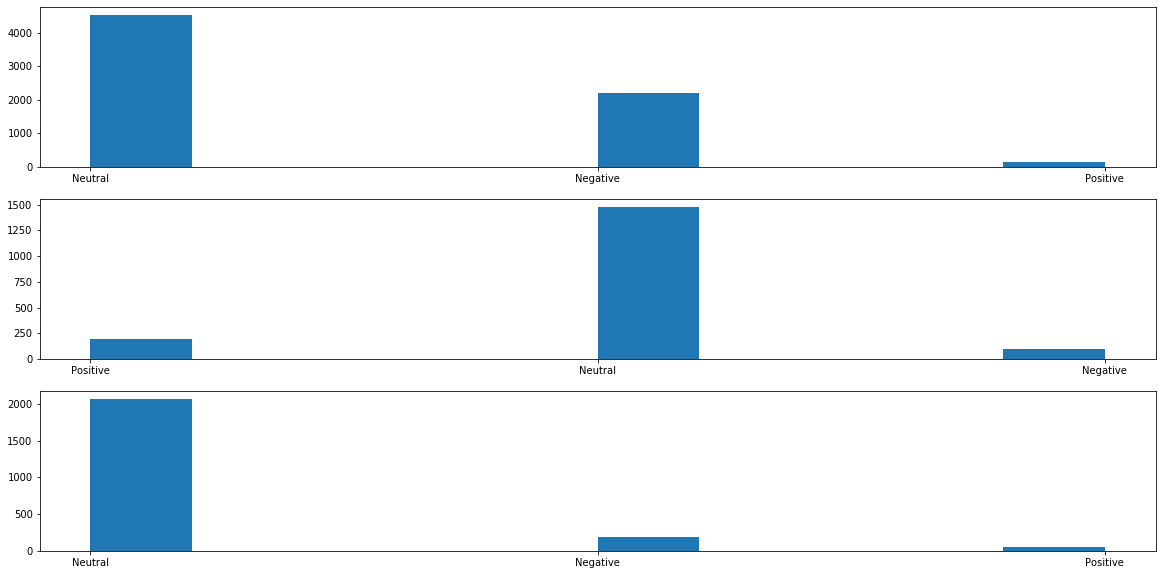

In [8]:
from nltk.corpus import opinion_lexicon
pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())
def opinion_lexicon_sentiment(sentence):
    senti = 0 
    words = str(sentence).split(' ')
    for word in words:
        if word in pos_list:
            senti += 1
        elif word in neg_list:
            senti -= 1
    return senti

sentiments_number = pd.Series([opinion_lexicon_sentiment(x) for x in X_train['text']])
sentiments = pd.cut(sentiments_number,bins=[-10,-1,1,10], labels=["Negative","Neutral","Positive"])
X_train['opinion_lexicon_sent'] = sentiments
X_train['sentiment_id'] = y_train
X_train['sentiments_number'] = sentiments_number
print(X_train[['sentiment_id', 'opinion_lexicon_sent', 'sentiments_number']].head(10))
# print(sentiments.value_counts())
# print(y_train['sentiment_id'].value_counts())
fig, axs = plt.subplots(3,figsize=(20, 10))
axs[0].hist(X_train[X_train['sentiment_id']==0]['opinion_lexicon_sent'])
axs[1].hist(X_train[X_train['sentiment_id']==1]['opinion_lexicon_sent'])
axs[2].hist(X_train[X_train['sentiment_id']==2]['opinion_lexicon_sent'])

In [24]:
ols = X_train['opinion_lexicon_sent']=='Neutral'
neg = X_train['sentiment_id']==0
X_train[ols&neg]['text'].head(20)

1          @AmericanAir merged airlines do not work for FF programs. Very frustrating and the gate agents are to busy pouting to care. #AttitudeIssues
5     @united, Thanks, but I didn't want to see 'we've started your flight search over' OR 'the fare &amp; rules for this itinerary has changed' again
6                   @AmericanAir when the pilot announces that the plane has been unused for 2 days and maintenance is dealing with another aircraft..
8                                                                                                           @USAirways #FAILINGYOURCUSTOMER ONE BY ONE
12                 @USAirways  but have to return car to clt can I skip my flgjt back tonight from gso to clt and pick up at clt to fll I was told yes
15                                            @United: I feel very well informed. yes, the flight is indeed delayed. Thank you. http://t.co/FuCHZRZjg5
18                                                                      @jetblue waiting for f

In [8]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
opinion_lexicon_pos,0,[1],0.034791,0.017304,0.001093
opinion_lexicon_neg,1,[0],0.804827,0.193078,0.103734
opinion_lexicon_neu,2,[2],0.160383,0.059745,0.059745
lf_contains_awesome,3,[1],0.077505,0.077505,0.064481
lf_contains_cancelled,4,[0],0.069854,0.069854,0.013024
lf_contains_complaint,5,[0],0.005191,0.005191,0.000911
lf_contains_delayed,6,[0],0.036430,0.036430,0.005009
lf_contains_thank_you,7,[1],0.115392,0.115392,0.107286


In [11]:
X_train['text'].iloc[L_train[:, 0]==POS].sample(10, random_state=1)

5493                                                    @united I'll be calling soon but going tomorrow like it shows on the app is not a good option
10901                                                   @united great flight into PVD. Smallest plane I have ever been on and smoothest landing ever!
3300                          @AmericanAir I don't think you should help him at all based on his behavior. The voucher and cot seem like enough lol 😃
5952                                   @SouthwestAir I'm in line at the airport right now. Will you cover hotel fair or am I to sleep in the airport?
8808          @SouthwestAir well I HAD a car &amp; free place 2 stay had I known Unacceptable treatment from Spvsr. Sally in Cleveland. #Disappointed
9688             @JetBlue @martysg Spoke to Corp. Customer Support already.  Shame.  Probably a reasonable and cheaper resolution to be had.  Regards
80       @USAirways found great prices thru US Air for honeymoon. Website wont work and been on hold

In [12]:
X_train['text'].iloc[L_train[:, 1]==NEG].sample(10, random_state=1)

6830                                                             .@united Let us know when you find everyone's luggage. Thanks. #UnitedAirlines
5760                                                                                            @USAirways you can send my luggage to my house👋
6504                                                                                                                 @USAirways I made it- thx.
9385                                                @JetBlue so technically I could drive to JFK now and put in. Request for tomorrow's flight?
1153           @JetBlue My card company and I explained the issue over the phone when I was in Mexico. I purchased a new ticket over the phone.
6397                                                                         @USAirways I know that, thanks. Evaluate further ;-) ... -Chairman
7657                                                 @United #1758 now going in 40 min waiting for other plane to vacate gate. #findanot

In [13]:
X_train['text'].iloc[L_train[:, 2]==NEU].sample(20, random_state=1)

4049                         @SouthwestAir thx for smooth landing today @fly2midway, we applauded! Now what can u do abt the weather? #takemeback http://t.co/OQZ7Wc4lLA
3545                                                                                                            @united 1632 was phenomenal frm gate (SEA) to gate (IAD)
8557                                                        @united no, I had to leave for work. Would have not been possible. So I would love to have this replaced now
5150                                    @united Good luck with the no-enertainment-on-6-hour-flights strategy. Innovation at work. Hello @jetblue http://t.co/HI76BOavXY
6445     @USAirways 4+ hour hold, finally Cancelled Flighted ticket! sticking to @delta @Expedia who allow easy online Cancelled Flights/refunds! http://t.co/RKVCZBpdCE
7205                                                        @united feck guys. Stop Cancelled Flightling flights from EWR to RIC the weather is fine I both

In [14]:
X_train['text'].iloc[L_train[:, 3]==POS].sample(10, random_state=1)

6460         @USAirways And, the helpful employee who changed her boarding zone so that she would have space for her pump is now being disciplined #fail
7419                                              @SouthwestAir you guys are so amazing for sending people to meet Imagine Dragons #DestinationDragons 😋
2599            @united doing a good thing, holding flight for a few for 11 peeps on Late Flight connecting flight. We'll still make destination on time
10380              @SouthwestAir Thanks 4 the great service, staff, letting me change my flight 5 times for free! PVD to the skies for me always on SWA!
6512          @AmericanAir thinks it's a good cs to get everyone through the gate for flight 4275 then we wait bc plane not ready http://t.co/rxmjWoo7Qi
4045                                                                                                                                    @JetBlue awesome
10857         @United THANK U! Secured room for the night Thx to VERY helpful cust

In [10]:
from labeling_funcs.tweets_lfs import *
lfs = [opinion_lexicon_pos, opinion_lexicon_neg, opinion_lexicon_neu,
                   lf_contains_awesome, lf_contains_cancelled, lf_contains_complaint,
                   lf_contains_delayed,lf_contains_thank_you,kmeans_pos, kmeans_neg, kmeans_neu]

In [14]:
print('applying labelling functions to data...')
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=X_train)
L_dev = applier.apply(df=X_dev)

print('fitting Label Model')
label_model = LabelModel(cardinality=config['cardinality'], verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)


  0%|          | 2/10980 [00:00<17:58, 10.18it/s]

applying labelling functions to data...



  3%|▎         | 300/10980 [00:59<36:43,  4.85it/s]


  5%|▌         | 596/10980 [02:06<38:21,  4.51it/s]


  8%|▊         | 892/10980 [03:09<35:15,  4.77it/s]


 11%|█         | 1186/10980 [04:12<36:14,  4.50it/s]


 13%|█▎        | 1478/10980 [05:15<33:15,  4.76it/s]


 16%|█▌        | 1770/10980 [06:23<34:52,  4.40it/s]


 19%|█▉        | 2062/10980 [07:39<31:41,  4.69it/s]


 21%|██▏       | 2354/10980 [08:48<39:37,  3.63it/s]


 24%|██▍       | 2646/10980 [10:02<29:52,  4.65it/s]


 27%|██▋       | 2938/10980 [11:07<27:25,  4.89it/s]


 29%|██▉       | 3230/10980 [12:20<29:18,  4.41it/s]


 32%|███▏      | 3522/10980 [13:26<28:23,  4.38it/s]


 35%|███▍      | 3814/10980 [14:30<27:43,  4.31it/s]


 37%|███▋      | 4106/10980 [15:33<28:42,  3.99it/s]


 40%|████      | 4398/10980 [16:32<21:19,  5.14it/s]


 43%|████▎     | 4690/10980 [17:31<20:40,  5.07it/s]


 45%|████▌     | 4982/10980 [18:29<20:57,  4.77it/s]


 48%|████▊     | 5274/10980 [19:29<19:30,  4.88it/s]


 51%|█████     | 5566/10980 [20:30<17:42,  5.09it/s]


 53%|█████▎    | 5858/10980 [21:31<16:54,  5.05it/s]


 56%|█████▌    | 6150/10980 [22:29<14:52,  5.41it/s]


 59%|█████▊    | 6442/10980 [23:29<16:41,  4.53it/s]


 61%|██████▏   | 6734/10980 [24:31<16:36,  4.26it/s]


 64%|██████▍   | 7026/10980 [25:40<15:18,  4.31it/s]


 67%|██████▋   | 7318/10980 [26:48<13:41,  4.46it/s]


 69%|██████▉   | 7610/10980 [28:04<13:25,  4.19it/s]


 72%|███████▏  | 7902/10980 [29:22<12:03,  4.25it/s]


 75%|███████▍  | 8194/10980 [30:30<11:17,  4.11it/s]


 77%|███████▋  | 8486/10980 [31:39<10:06,  4.11it/s]


 80%|███████▉  | 8778/10980 [32:49<09:01,  4.07it/s]


 83%|████████▎ | 9070/10980 [33:59<09:02,  3.52it/s]


 85%|████████▌ | 9362/10980 [35:12<07:05,  3.80it/s]


 88%|████████▊ | 9654/10980 [36:23<05:41,  3.88it/s]


 91%|█████████ | 9946/10980 [37:35<04:04,  4.23it/s]


 93%|█████████▎| 10233/10980 [38:45<03:08,  3.96it/s]


 96%|█████████▌| 10519/10980 [39:55<01:58,  3.87it/s]


 98%|█████████▊| 10805/10980 [41:05<00:44,  3.89it/s]


100%|██████████| 10980/10980 [41:48<00:00,  4.38it/s]

  3%|▎         | 120/3660 [00:29<14:19,  4.12it/s]


 12%|█▏        | 422/3660 [01:41<12:53,  4.19it/s]


 20%|█▉        | 724/3660 [02:54<11:55,  4.10it/s]


 28%|██▊       | 1026/3660 [04:08<09:56,  4.42it/s]


 36%|███▌      | 1322/3660 [05:20<09:09,  4.25it/s]


 44%|████▍     | 1618/3660 [06:31<08:43,  3.90it/s]


 52%|█████▏    | 1914/3660 [07:42<07:30,  3.88it/s]


 60%|██████    | 2210/3660 [08:51<05:50,  4.13it/s]


 68%|██████▊   | 2506/3660 [10:01<04:16,  4.49it/s]


 77%|███████▋  | 2802/3660 [11:09<03:10,  4.51it/s]


 85%|████████▍ | 3098/3660 [12:17<02:06,  4.45it/s]


 93%|█████████▎| 3394/3660 [13:24<00:59,  4.49it/s]


100%|██████████| 3660/3660 [14:25<00:00,  4.23it/s]


fitting Label Model


In [15]:
label_model.score(L_dev, y_dev, tie_break_policy="random")["accuracy"]

0.5950819672131148

In [16]:
majority_model = MajorityLabelVoter(cardinality=config['cardinality'])
majority_acc = majority_model.score(L=L_dev, Y=np.array(y_dev).reshape(-1,1), tie_break_policy="random")["accuracy"]

In [17]:
majority_acc

0.42349726775956287

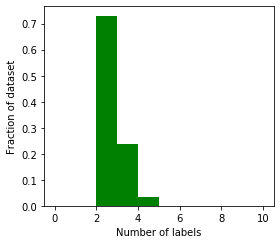

In [55]:
def plot_label_frequency(L):
    plt.figure(figsize=(4., 3.5))
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]), color='green')
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.tight_layout()
    plt.savefig('figures/tweets_lfs_label_freq.png', dpi=500)
    plt.show()

plot_label_frequency(L_train)

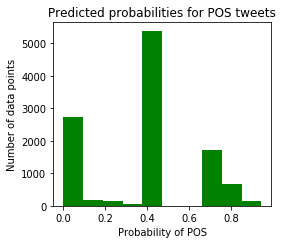

In [60]:
def plot_probabilities_histogram(label_text, savefile, Y):
    plt.figure(figsize=(4., 3.5))
    plt.hist(Y, bins=10, color='green')
    plt.xlabel(f'Probability of {label_text}')
    plt.ylabel("Number of data points")
    plt.title(f'Predicted probabilities for {label_text} tweets')
    plt.tight_layout()
    plt.savefig(f'figures/{savefile}', dpi=500)
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram('POS', 'tweets_pred_proba_pos.png', probs_train[:, POS])

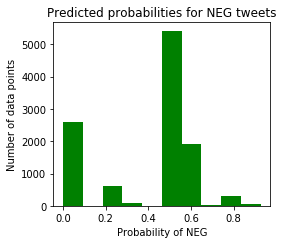

In [61]:
plot_probabilities_histogram('NEG', 'tweets_pred_proba_neg.png', probs_train[:, NEG])

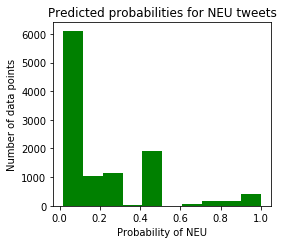

In [62]:
plot_probabilities_histogram('NEU', 'tweets_pred_proba_neu', probs_train[:, NEU])